In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE, r2_score as R2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from pprint import pprint


In [30]:
plt.style.use('ggplot')

In [6]:
processed_folder = Path.cwd().parent / 'data' / 'processed' 

In [56]:
df = pd.read_parquet(processed_folder / 'df_model_tidy.parquet')
df.describe()

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
count,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000,248672.000000
mean,69.994932,37198.214057,59.478817,10.224778,44.535311,38.835690,75.151171,91.972379,50.646395,2.079548,40.917864,45.007025,88.513865
std,6.229999,4247.285214,8.300112,5.224164,17.236554,13.590214,3.216025,11.868203,14.982034,2.422668,22.225903,29.563685,3.515651
min,49.134859,21125.088265,24.500046,0.000000,0.000000,10.703177,43.222900,0.000000,0.000000,0.000000,0.021956,1.238072,68.339688
25%,65.786279,34700.961268,55.836040,6.180227,31.130319,28.893682,73.730388,94.225297,43.721163,0.228938,21.758819,20.792965,86.225484
50%,72.235727,38372.263848,61.402165,10.437074,44.740149,37.051952,75.858501,94.916176,50.585868,1.214717,45.680865,33.483420,88.464203
75%,75.737066,40374.792528,64.927556,13.526586,55.344245,47.961942,77.686504,95.619150,58.419725,3.242836,59.587541,78.600327,90.860663
max,75.820134,45390.650079,75.371860,49.926609,100.000000,91.966382,81.595704,100.000000,100.000000,63.578701,91.597141,100.000000,100.000000


<Axes: xlabel='presion', ylabel='Count'>

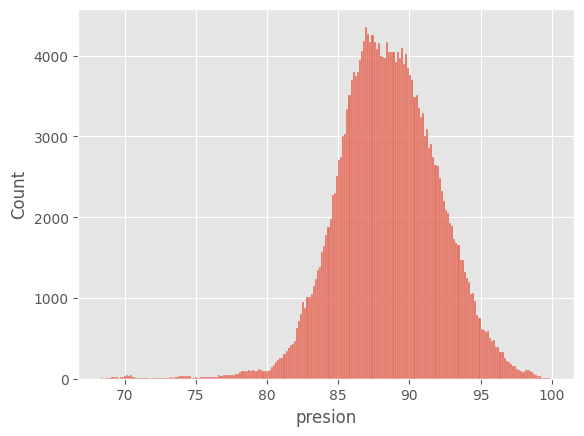

In [34]:
#para refrescar rago de valores
sns.histplot(y)

# Intento inicial regresión lineal

Se hará una regresión lineal con el objetivo de entender la problematico como un problema de aprendizaje automatico. El objetivo es ver que variables tienen mayor peso para la presión, que variables podemos descartar y que estrategias podemos implementar para tener un modelo útil para la operación.

In [17]:
#separacion en train y test
X = df.iloc[:, :-1]
y = df.presion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68)


In [79]:
#se hace pipeline para escalamiento de variables
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', LinearRegression()) #no se agregan hiperparametros por el objetivo de entender el problema
])

#se ajusta el modelo
pipeline.fit(X_train, y_train) 

#predicciones en test y train
y_train_hat = pipeline.predict(X_train)
y_test_hat = pipeline.predict(X_test)

In [105]:
print(f"número de datos entrenamiento {X_train.shape[0]}")
print(f"número de datos test {X_test.shape[0]}")

número de datos entrenamiento 198937
número de datos test 49735


Text(0, 0.5, 'presion real')

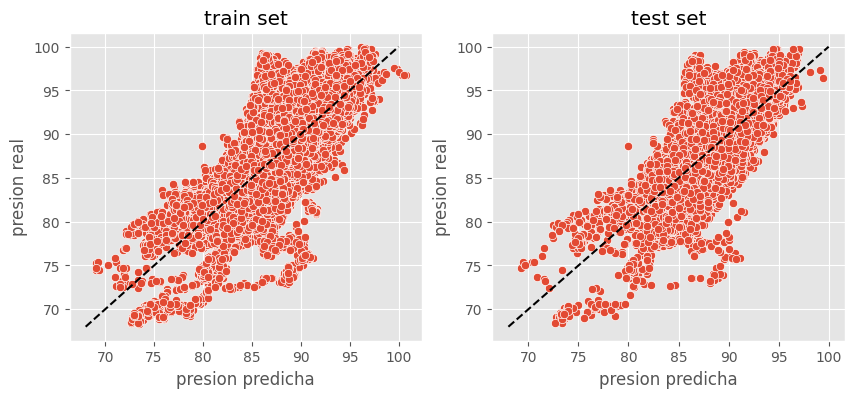

In [87]:
#vizualizacion resultados
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

#ax0
sns.scatterplot(x = y_train_hat, 
                y = y_train,
               ax = axs[0])

sns.lineplot(x = [68, 100],
             y = [68, 100],
            color = 'black',
             linestyle = '--',
            ax = axs[0])

axs[0].set_title("train set")

axs[0].set_xlabel("presion predicha")
axs[0].set_ylabel("presion real")

#ax1
sns.scatterplot(x = y_test_hat, 
                y = y_test,
               ax = axs[1])

sns.lineplot(x = [68, 100],
             y = [68, 100],
            color = 'black',
             linestyle = '--',
            ax = axs[1])

axs[1].set_title("test set")
axs[1].set_xlabel("presion predicha")
axs[1].set_ylabel("presion real")

In [83]:
mae_t1_train = mae(y_train, y_train_hat)
mae_t1_test = mae(y_test, y_test_hat)

print(f"error medio absoluto en train {mae_t1_train:.2f}")
print(f"error medio absoluto en test {mae_t1_test:.2f}")

error medio absoluto en train 1.78
error medio absoluto en test 1.77


In [89]:
R2_t1_train = R2(y_train, y_train_hat)
R2_t1_test = R2(y_test, y_test_hat)

print(f"R2 en train {R2_t1_train:.2f}")
print(f"R2 en test {R2_t1_test:.2f}")

R2 en train 0.58
R2 en test 0.58


In [99]:
var_names = X.columns
var_coeficient_abs = abs(pipeline.named_steps['regressor'].coef_)
sign_coeficient = np.sign(pipeline.named_steps['regressor'].coef_)                

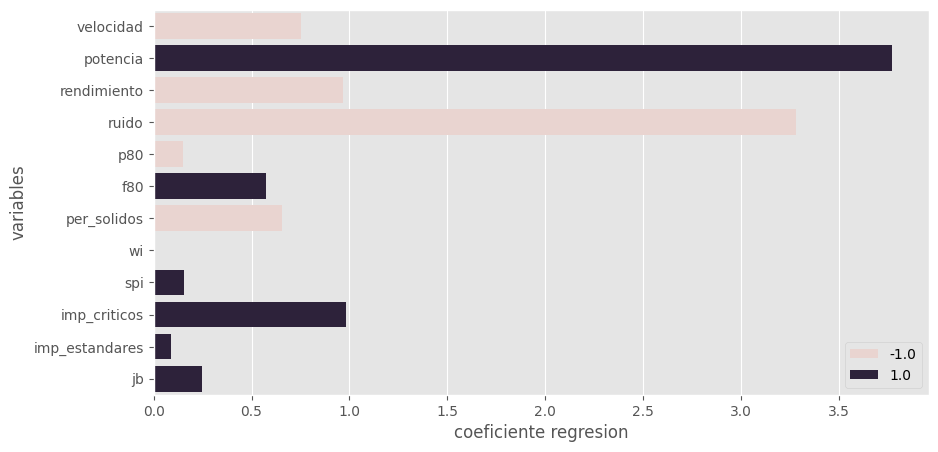

In [102]:
#visualizacion "importancia" variables
fig, ax = plt.subplots(figsize =(10, 5))

sns.barplot(y = X.columns, 
            x = var_coeficient_abs,
            hue = sign_coeficient,
           orient = 'h')

ax.set_xlabel("coeficiente regresion")
ax.set_ylabel("variables");
# ax.legend(loc='upper right', labels=['Negativo', 'Positivo'])


Del valor de los coeficientes de la regresion lineal se puede obtener informacion util para los siguientes modelos:

* El coeficiente positivo del tamaño de la bola (f80) sugiere que a medida que aumenta el tamaño de la bola, el material tarda más en salir del molino, lo que resulta en un aumento de la presión. Esto se debe una menor eficiencia de molienda con rocas más grandes.

* El coeficiente negativo de la variable per_solidos indica que un mayor contenido de agua en relación con el tonelaje cargado conlleva a una descarga más rápida del molino y, por lo tanto, a una disminución de la presión. 

* EL valo alto del coeficiente de ruido es de esperar por la naturaleza de esta variable, el ruido cambia conforme cambia el nivel de llenado del molino.

* Las variables wi parecen tener un efecto insignificante en el modelo y será excluida en proximos modelos.

* La variable spi tiene un efecto mínimo pero significativo en el modelo, lo que sugiere que puede contribuir ligeramente a la predicción de la presión del molino.

* Los impactos críticos tienen un peso mayor en el modelo en comparación con los impactos estándares, haciendo despreciable la variabla de impactos estandares

* El coeficiente negativo para la velocidad es de los evidentes al igual que la potencia. Entre más rapido gira el molino, más rapido es la molienda y la descarga del mineral.

En relación a la operación del molino, hay dos aspectos que no se están considerando en los datos actuales: el desgaste del revestimiento y la incertidumbre asociada a la variable jb.

El desgaste del revestimiento, aunque no parece tener un impacto inmediato de semana a semana, muestra una tendencia marcada a medida que avanza la campaña del molino. Aunque en el período de un mes presente en los datos, este efecto podría ser insignificante, es importante tener en cuenta que se tendra un sesgo por ese lado. Una manera de atacar este problema es creando una variable que indique cuanto tiempo a pasado desde la instalación del revestimiento actual, de tal manera que esta describa el efecto de la perdida de peso por el desgaste.

Por otro lado, la variable jb presenta una fuente de incertidumbre significativa en su estimacion. El modelo utilizado para su estimación utiliza valores acumulados, lo cual puede resultar en un error considerable, especialmente en situaciones donde se producen pérdidas de datos. 

